# Feed Forward Neural Network with Linear Algebra
> <span style="color:gray"> Created by Mikkel Vilstrup ([mvil](https://github.com/MVilstrup))

In the former notebook we developed a simple toy network with one unit and went manually through backpropagation. It was tedius work with just one unit, to do this manually for more complicated networks would be almost impossible. Luckily for us, almost all the operations needed for propagating the inputs through the neural network and updating the weights afterwards can be calculated efficiently using linear algebra. 

*N.B is you are not fully comfortable you might want to look at our notebook **OPT_Pure_Python**. Here we build a neural network without the use of Linear Algebra. We also introduce several different activation functions in this notebook. These might be beneficial to get comfortable with*

In this notebook we are going to use the scientific computing library Numpy to define a more complicated network. We do this to show how much more compact the network can be formulated if we use concepts from linear algebra. 
When we afterwards use specialized deep learning frameworks to define the networks, it is important to remember that these are based on linear algebra as well, and are doing almost the same as we do here. 

The biggest difference is that they include advanced techniques for redundant operations and use the available hardware optimally.

## Dependencies and supporting functions
Load all dependancies and supporting functions by running the code block below.

In [1]:
%matplotlib inline
import sys, os
sys.path.append(os.path.join('.', '..')) # in order to import various .py files
from time import sleep
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from intro_utils import *

from IPython.display import clear_output
from IPython import display

from sklearn.datasets import make_moons
from sklearn.metrics import precision_score, accuracy_score

## Define activation function and cost function

When doing classification with neural network we most often want the output to be a probability distribution over the available classes since this enable us to quantify how sure we are of a certain prediction. 

Whenever we use the softmax as an activation function in the final layer, we tend to use the cross entropy as our loss function. This is because the derivative of the cross entropy function works well with the derivative of the softmax function when doing backpropagation with a better preforming models as a result.

In [2]:
def softmax(values):
    exp_scores = np.exp(values)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def cross_entropy(model, X, Y):
    hidden_weights, output_weights = model['HW'], model['OW']
    probs = predict(model, X, get_probs=True)
    
    num_examples = len(Y)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), Y])
    data_loss = np.sum(corect_logprobs)
    
    return 1. / num_examples * data_loss

# Defining the model

The fully connected architecture we are trying to define can be visualized in the following manner: 

![alt text](images/ffn.png "Fully Connected Neural Net")

Each hidden unit $h_i$ in each layer is connected to all the units in the former layer.
The weights of a layer can therefore be defined as a matrix $M$ with one row for every hidden unit in the former layer and one column for every unit in the current layer.
We also want to add a bias vector $b_i$ to each hidden unit $h_i$ (i.e. same number of elements as there are columns in the matrix).
Mathematically this equals the function: 

$$ Y = X \cdot H + b $$

So in forward propagation we multiply each layer-matrix with its input and add a bias vector.
We then apply an activation function to the result and pass the output of this activation function as the input to the next layer.

Backpropagation is a bit more tricky, and we will not go into detail with it here. However, if you have gone through our notebook of backpropagation you shuld have understood it by now.

Our model is much simpler than the general model sketched above. We have 1 input layer, 1 hidden layer and 1 output layer. 

In [3]:
def build_model(train_data,
                test_data,
                input_dimensions = 2,
                hidden_dimensions = 3,
                output_dimensions = 2,
                epochs = 1000,
                learning_rate = 0.01):
    
    X_train, Y_train = extract_data(train_data)
    X_test, Y_test = extract_data(test_data)
    
    # Define the necessary weights and biases
    # This time we normalize the random weights which is common practice (but done behind the scenes)
    hidden_weights = np.random.randn(input_dimensions, hidden_dimensions) / np.sqrt(input_dimensions)
    output_weights = np.random.randn(hidden_dimensions, output_dimensions) / np.sqrt(hidden_dimensions)
    
    hidden_bias = np.zeros((1, hidden_dimensions)) # The bias related to the weights
    output_bias = np.zeros((1, output_dimensions)) # The bias related to the weights
    
    # We define a dictionary to maintain the state of the network
    # this could be done in many other ways as well
    model = { 
        "HW": hidden_weights,
        "HB": hidden_bias,
        "OW": output_weights,
        "OB": output_bias
    }
    
    test_loss = []
    train_loss = []
    
    #   ------------- Code for plotting -------------
    #   ---------- DON'T WORRY ABOUT THIS -----------
    xx_train, yy_train = mesh_grid(X_train)
    xx_test, yy_test = mesh_grid(X_test)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))
    ax1.scatter(X_train[:, 0], X_train[:, 1], s=60, cmap=plt.cm.coolwarm)
    ax2.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, s=60, cmap=plt.cm.coolwarm)
    
    fig.suptitle("Epoch: 0", fontsize=20)
    plot(model, ax1, X_train, Y_train, "Train", xx_train, yy_train)
    plot(model, ax2, X_test, Y_test, "Test", xx_test, yy_test)
    plot_error(ax3, train_loss, test_loss)
    sleep(2) 
    #   ^^^^^^^^^^^^ End of plotting code ^^^^^^^^^^^^
        
    #  ------------- TRAINING THE MODEL -------------  
    for i in range(1, epochs + 1):
        #  ------------- FORWARD PROPAGATION -------------
        hidden_values = X_train.dot(hidden_weights) + hidden_bias
        hidden_activations = np.tanh(hidden_values) # N.B we use TanH Activation Function
        output_values = hidden_activations.dot(output_weights) + output_bias
        probs = softmax(output_values)

        #  ------------- BACKPROPAGATION -------------
        output_delta = probs
        output_delta[range(len(X_train)), Y_train] -= 1
        output_weights_delta = (hidden_activations.T).dot(output_delta)
        output_bias_delta = np.sum(output_delta, axis=0, keepdims=True)
        
        # Here we take the derivative of Tanh and multiplies it with the output delta
        tan_h_derivative = (1 - np.power(hidden_activations, 2))
        hidden_delta = output_delta.dot(output_weights.T) * tan_h_derivative
        
        hidden_weights_delta = np.dot(X_train.T, hidden_delta)
        hidden_bias_delta = np.sum(hidden_delta, axis=0)
        
        #  ------------- UPDATE WEIGHTS (Gradient Descent) -------------

        # Gradient descent parameter update
        output_weights += -learning_rate * output_weights_delta
        output_bias += -learning_rate * output_bias_delta
        
        hidden_weights += -learning_rate * hidden_weights_delta
        hidden_bias += -learning_rate * hidden_bias_delta
        
        # Update the state of the model
        model = { 
            "HW": hidden_weights,
            "HB": hidden_bias,
            "OW": output_weights,
            "OB": output_bias
        }
        
        #   ------------- Code for plotting -------------
        #   ---------- DON'T WORRY ABOUT THIS -----------
        if i % 20 == 0:
            fig.suptitle("Epoch: {}".format(i), fontsize=20)
            plot(model, ax1, X_train, Y_train, "Train", xx_train, yy_train)
            plot(model, ax2, X_test, Y_test, "Test", xx_test, yy_test)
            plot_error(ax3, train_loss, test_loss)
            display.clear_output(wait=True)
            display.display(plt.gcf())
        
        test_loss.append(cross_entropy(model, X_test, Y_test))
        train_loss.append(cross_entropy(model, X_train, Y_train))
        #   ^^^^^^^^^^^^ End of plotting code ^^^^^^^^^^^^

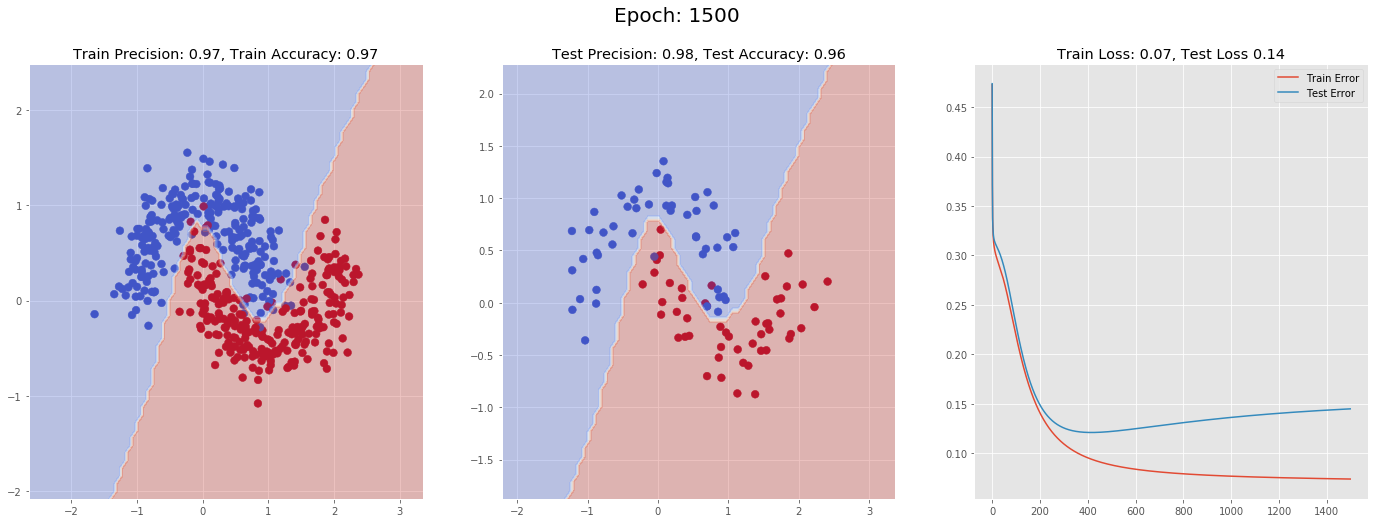

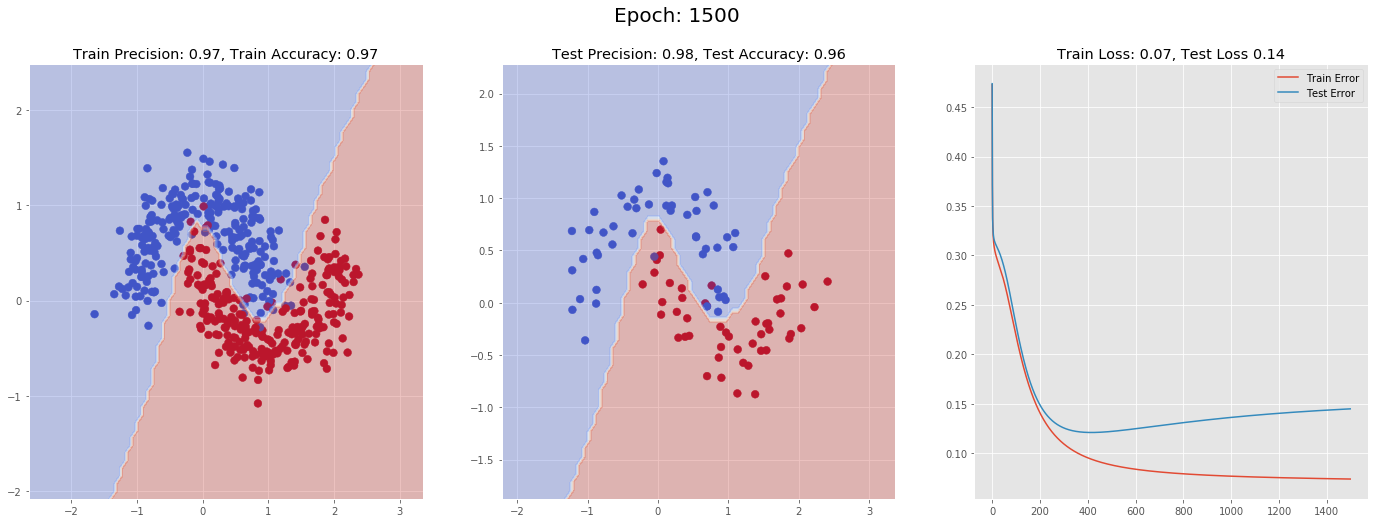

In [4]:
train_size = 500
test_size = 100

X_train, Y_train = make_moons(train_size, noise=0.2)
X_test, Y_test = make_moons(test_size, noise=0.2)


train_data = list(zip(X_train, Y_train))
test_data = list(zip(X_test, Y_test))

LEARNING_RATE = 0.001
HIDDEN_DIMENSIONS = 50
EPOCHS = 1500

build_model(train_data, 
            test_data, 
            epochs=EPOCHS,
            hidden_dimensions=HIDDEN_DIMENSIONS,
            learning_rate=LEARNING_RATE)

# Assignments

 1) Try to play around with the learning rate and note what happens
 
 2) Add another layer to the network